In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import warnings
import math
from scipy.optimize import curve_fit
from collections import deque, defaultdict
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


In [2]:
def connectivityExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    connectivity_raw = data_structure['connectivity'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    connectivity_data = connectivity_raw.squeeze()
    # Create a DataFrame from the connectivity data
    connectivity_df = pd.DataFrame(connectivity_data, columns=['Parent', 'Daughter1', 'Daughter2', 'Daughter3'])
    connectivity_df.replace(0, np.nan, inplace=True) #ensure all nonexistent vessels have NaN
    connectivity_df.at[0,'Parent']=0 #make sure first vessel is 0 (purposefully removed in last step for ease)
    # Save the DataFrame to inspect it
    return connectivity_df

def lengthExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'lengths' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    length_raw = data_structure['lengths'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    length_data = length_raw.squeeze()
    # Create a DataFrame from the data
    length_df = pd.DataFrame(length_data, columns=['Length'])
    # Save the DataFrame to inspect it
    return length_df

def radiusExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'radius' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    radius_raw = data_structure['rin'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    radius_data = radius_raw.squeeze()
    # Create a DataFrame from the data
    radius_df = pd.DataFrame(radius_data, columns=['Radius'])
    # Save the DataFrame to inspect it
    return radius_df

def volumeExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name + '.mat'
    matlab_data = scipy.io.loadmat(file_path)
    volume_raw = matlab_data['volumes']  # This is an x by 1 or 1D array
    volume_data = volume_raw.squeeze()  # Converts to 1D array if it's still 2D with 1 column
    volume_df = pd.DataFrame(volume_data, columns=['Volume'])
    return volume_df

def lRR(data):
    lrr = np.empty((0,0))
    for i in np.arange(data.shape[0]): #iterate over every vessel
        length = data.iloc[i]['Length'] #pull the length value
        radius = data.iloc[i]['Radius'] #retreive radius value
        lrr_value = length/radius #calculate lrr
        lrr = np.append(lrr,lrr_value) #append lrr value to total list
    data['Length/Radius'] = lrr.tolist() #add list to table
    return data

def assignDepth(data):
    tree = {} 
    for _, row in data.iterrows(): #iterate over every row
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist() #only select daughter values that exist
        tree[parent] = daughters
    # Step 2: BFS traversal to assign depths
    depths = {}
    queue = deque([(data['Parent'].iloc[0], 0)])  # Start from root (first parent)

    while queue:
        node, depth = queue.popleft()
        depths[node] = depth
        for child in tree.get(node, []):
            if child not in depths:  # Avoid revisiting
                queue.append((child, depth + 1))
    data['Depth'] = data['Parent'].map(depths)
    return data

def lengthFromRoot(data):
    tree = {}
    length_dict = dict(zip(data['Parent'], data['Length']))  # Map each vessel (parent) to its length

    for _, row in data.iterrows():
        parent = row['Parent']
        daughters = row[['Daughter1', 'Daughter2', 'Daughter3']].dropna().astype(int).tolist()
        tree[parent] = daughters

    # BFS traversal to calculate cumulative lengths
    lengths = {}
    root = data['Parent'].iloc[0]
    queue = deque([(root, 0)])  # Start with cumulative length 0

    while queue:
        node, cum_length = queue.popleft()
        lengths[node] = cum_length
        for child in tree.get(node, []):
            if child not in lengths:  # Avoid revisiting
                additional_length = length_dict.get(child, 0)
                queue.append((child, cum_length + additional_length))

    data['LengthFromRoot'] = data['Parent'].map(lengths)
    return data

def nodesExtractor(name): #extracts nodes and their corresponding information
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'nodes' field
    data_structure = matlab_data['nodesC2']
    # Reshape or ensure it's a proper 2D array (if required)
    nodes_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    nodes_df = pd.DataFrame(nodes_data, columns=['NodeID', 'X', 'Y', 'Z', 'Degree'])
    # Save the DataFrame to inspect it
    return nodes_df

def edgesExtractor(name): #extracts segments to create a dataframe of from and to nodes
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'segments' field
    data_structure = matlab_data['segments']
    # Reshape or ensure it's a proper 2D array (if required)
    edges_data = data_structure.squeeze()
    # Create a DataFrame from the connectivity data
    edge_df = pd.DataFrame(edges_data, columns=['Old', 'From', 'To'])
    # Save the DataFrame to inspect it
    return edge_df

def mapIDExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'mapID' field from the 'Data' structured array
    data_structure = matlab_data['Data']
    map_raw = data_structure['mapIDs'][0, 0]  # Access the data (adjust indexing if needed)
    # Reshape or ensure it's a proper 2D array (if required)
    map_data = map_raw.squeeze()
    # Create a DataFrame from the connectivity data
    map_df = pd.DataFrame(map_data, columns=['New', 'Old'])
    # Save the DataFrame to inspect it
    return map_df

def tortuosityCalculator(data,name):
    nodes = nodesExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    tortuosity = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        old_vesID = maps.iloc[i]['Old'] #find the old vessel ID
        edge_row = edges.index.get_loc(edges[edges['Old'] == old_vesID].index[0])
        node1 = edges.iloc[edge_row]['From'] #identify from node
        node2 = edges.iloc[edge_row]['To'] #identify to node
        node1_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node1].index[0])
        node2_row = nodes.index.get_loc(nodes[nodes['NodeID'] == node2].index[0])
        node1_x = nodes.iloc[node1_row]['X'] #pull node 3d coordinate
        node1_y = nodes.iloc[node1_row]['Y']
        node1_z = nodes.iloc[node1_row]['Z']
        node2_x = nodes.iloc[node2_row]['X']
        node2_y = nodes.iloc[node2_row]['Y']
        node2_z = nodes.iloc[node2_row]['Z']
        euclid_dist = math.sqrt((node1_x - node2_x)**2 + (node1_y - node2_y)**2 + (node1_z - node2_z)**2) #calculate euclidean distance between from and to
        length = data.iloc[i]['Length'] #pull length and convert to mm
        ratio = length/euclid_dist #find tortuosity ratio
        tortuosity = np.append(tortuosity,ratio)
    data['Tortuosity'] = tortuosity.tolist() #add to table
    return data

def radiusFinder(data):
    dv1r = np.empty((0,0))
    dv2r = np.empty((0,0))
    dv3r = np.empty((0,0))
    for i in np.arange(data.shape[0]):# iterate over every row
        dv1 = data.iloc[i]['Daughter1'] #pull radii values
        dv2 = data.iloc[i]['Daughter2']
        dv3 = data.iloc[i]['Daughter3']
        if math.isnan(dv1): #if daughter vessel 1 doesn't exist, none of them do
            dv1r = np.append(dv1r,np.nan)
            dv2r = np.append(dv2r,np.nan)
            dv3r = np.append(dv3r,np.nan)
            continue
        dv1r = np.append(dv1r,data.iloc[int(dv1)][2])
        dv2r = np.append(dv2r,data.iloc[int(dv2)][2])
        if math.isnan(dv3): #explicitly check whetehr dv3 exist
            dv3r = np.append(dv3r,np.nan)
            continue
        dv3r = np.append(dv3r,data.iloc[int(dv3)][2])
    data['DV1R'] = dv1r.tolist()
    data['DV2R'] = dv2r.tolist()
    data['DV3R'] = dv3r.tolist()
    #select and reorder columns
    data = data.loc[:,['Parent','Depth','Length','Radius','Volume', 'Length/Radius','LengthFromRoot','Tortuosity','Daughter1','DV1R','Daughter2','DV2R','Daughter3','DV3R']]
    return data

def alphaBeta(data):
    alpha = np.empty((0,0))
    beta = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #check if trifurcation, if it is then don't calculate
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R']
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #check if daughter vessels exist
            alpha = np.append(alpha,np.nan)
            beta = np.append(beta,np.nan)
            continue
        if dv1r>=dv2r: #case 1 of daughter vessels
            alpha_value = dv1r/pv
            beta_value = dv2r/pv
        else: #case 2 of daughter vessels
            alpha_value = dv2r/pv
            beta_value = dv1r/pv
        alpha = np.append(alpha,alpha_value)
        beta = np.append(beta,beta_value)
    data['Alpha'] = alpha.tolist() #add alpha and beta to total table
    data['Beta'] = beta.tolist()
    return data

def xiFinder(data):
    xi_values = np.empty((0,0))
    error_values = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        rp = data.iloc[i]['Radius'] #pull all radii
        rd1 = data.iloc[i]['DV1R']
        rd2 = data.iloc[i]['DV2R']
        rd3 = data.iloc[i]['DV3R']
        if not math.isnan(rd3): #don't calculate if trifucation
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        if math.isnan(rd1): #don't calculate if no daughter vessels
            xi_values = np.append(xi_values,np.nan)
            error_values = np.append(error_values,np.nan)
            continue
        xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        while abs(error) > 1e-4: #allow for error up to 10^-4
            fun = rp**xi - rd1**xi - rd2**xi # solve at f(xi)
            fun2 = (rp**xi)*math.log(rp) - (rd1**xi)*math.log(rd1) - (rd2**xi)*math.log(rd2) #solve at f'(xi)
            xi = xi - fun/fun2 # new xi value
            error = rp**xi - rd1**xi - rd2**xi #calculate new error
        if xi > 6: #bound xi
            xi = 6
        if xi < 1:
            xi = 1
        error = rp**xi - rd1**xi - rd2**xi
        xi_values = np.append(xi_values,xi)
        error_values = np.append(error_values,error)
    data['Xi'] = xi_values.tolist()#add xi to the table
    #data['Error Newton'] = error_values.tolist()
    return data

def asymmetry(data):
    asym = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #don't calculate if trifucation
            asym = np.append(asym,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull radii
        dv2r = data.iloc[i]['DV2R']
        if math.isnan(dv1r): #if no daughters, skip
            asym = np.append(asym,np.nan)
            continue
        if dv1r>=dv2r: #case 1
            asym_value = (dv2r/dv1r)**2
        else: #case 2
            asym_value = (dv1r/dv2r)**2
        asym = np.append(asym,asym_value)
    data['Gamma'] = asym.tolist() #add to table
    return data

def area(data):
    area = np.empty((0,0))
    for i in np.arange(data.shape[0]):
        if not math.isnan(data.iloc[i]['DV3R']): #if trifucation, skip
            area = np.append(area,np.nan)
            continue
        dv1r = data.iloc[i]['DV1R'] #pull necessary radii
        dv2r = data.iloc[i]['DV2R']
        pv = data.iloc[i]['Radius']
        if math.isnan(dv1r): #if no daughters, skip
            area = np.append(area,np.nan)
            continue
        area_value = (dv1r**2+dv2r**2)/(pv**2) #calculate eta
        area = np.append(area,area_value)
    data['Eta'] = area.tolist() #add to table
    return data

def angleExtractor(name):
    file_path = 'Networks/Network_Vessels_' + name +'.mat'
    matlab_data = scipy.io.loadmat(file_path)
    # Extract the 'connectivity' field from the 'Data' structured array
    angles = matlab_data['Angles']
    headers = [str(h.item()) if isinstance(h,np.ndarray) else str(h) for h in angles[0]]
    columns = [angles[1,i].squeeze() for i in range(len(headers))]
    angled = pd.DataFrame(dict(zip(headers,columns)))
    return angled

def matchAngles(data,name):
    angles = angleExtractor(name)
    edges = edgesExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, edges, on='Old', how='left')
    angleID = pd.merge(newOldIDs,angles,left_on='To',right_on='hubNode')
    angleID.drop(['Old','From','To','hubNode'],axis=1,inplace=True)
    #vesAngle = angleID.merge(data,left_on='New',right_on='Parent',how='left')
    angled = data.merge(angleID,left_on='Parent',right_on='New',how='left')
    angled = angled.drop(columns='New')
    return angled

def dataExtractor(name): #sequentially calls necessary functions to create full table
    connectivity = connectivityExtractor(name)
    length = lengthExtractor(name)
    radius = radiusExtractor(name)
    volume = volumeExtractor(name)
    combined = pd.concat([connectivity.iloc[:, :1], length, radius, volume, connectivity.iloc[:, 1:]], axis=1)
    lengthradius = lRR(combined)
    #print('LRR')
    depthness = assignDepth(lengthradius)
    #print('Depth')
    lengthTotal = lengthFromRoot(depthness)
    #print('LengthFromRoot')
    tortuos = tortuosityCalculator(lengthTotal,name)
    #print('Tortousity')
    allradii = radiusFinder(tortuos)
    angled = matchAngles(allradii,name)
    alphabetazed = alphaBeta(angled)
    #print('Alpha/beta')
    xi = xiFinder(alphabetazed)
    #print('Xi')
    asymmetric = asymmetry(xi)
    #print('Gamma')
    areated = area(asymmetric)
    return areated

def saveStatistics(name): #saves the stats as .csv for exporting
    statistics = dataExtractor(name)[["Parent", "Depth",'Length','Radius','Volume','Length/Radius','LengthFromRoot','Tortuosity','Alpha','Beta','Xi','Gamma','Eta']] #selects correct columns
    file_path = 'Statistics/Statistics_' + name +'.csv'
    statistics.to_csv(file_path) #shouldn't return anything, just save

def leaveDetails(statistics):
    #statistics = dataExtractor(name)
    dropped = statistics.dropna(subset='DV1R')
    internal = dropped.shape[0]
    tris = dropped['DV3R'].count()
    leaves = statistics['DV1R'].isna().sum()
    triratio = tris/internal * 100
    avgdepth = statistics[statistics['Daughter1'].isna()]['Depth'].mean()
    stddepth = statistics[statistics['Daughter1'].isna()]['Depth'].std()
    volume = statistics['Volume'].sum()/(1000**3)
    #print(name)
    print('# of vessels: ' + str(statistics.shape[0]))
    print('# of leaves (terminal vessels): ' + str(leaves))
    print('# of internal vessels: ' + str(internal))
    print('# of trifurcations: '+ str(tris))
    print('% of trifurcations: ' + str(round(triratio,3)))
    print('Volume (mm^3): ' + str(round(volume,3)))
    print('Average Depth of terminal vessel: ' + str(round(avgdepth,3)))
    print('St. Dev. Depth of terminal vessel: ' + str(round(stddepth,3)))


# Data Extraction

In [3]:
#Control Mice
control1 = dataExtractor('m1p1_060407')
control2 = dataExtractor('m2p1_060407')
control3 = dataExtractor('m3p1_060407')
control4 = dataExtractor('m1p1_060507')
control5 = dataExtractor('m2p1_060507')
control6 = dataExtractor('m3p1_060507')
control7 = dataExtractor('m2p1_060607')
control8 = dataExtractor('m3p1_060607')

In [4]:
# Hypertensive Mice
hyper1 = dataExtractor('m1p1_053007')
hyper2 = dataExtractor('m2p1_053007')
hyper3 = dataExtractor('m1p1_053107')
hyper4 = dataExtractor('m2p1_053107')
hyper5 = dataExtractor('m1p1_060107')

# Comparisons

In [5]:
def lobeInput(name,fromnode,tonode):
    segments = segmentExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, segments, on='Old', how='left')
    newVesID = int(newOldIDs[((newOldIDs['From'] == fromnode)&(newOldIDs['To']==tonode))].iloc[0,0])
    lobe = lobeExtractor(name,newVesID)
    return lobe

def offPrincipalPath(data):
    # Initialize BFS queue and results
    queue = deque([0])  # Start with the first row
    visited = set()
    principal_path = []

    # Get the initial radius
    root_radius = data.loc[0, 'Radius']

    while queue:
        current = queue.popleft()
        if current in visited:
            continue
        visited.add(current)
        principal_path.append(current)

        # Parent radius
        parent_radius = data.loc[current, 'Radius']

        # Check each daughter
        for i in range(1, 4):
            daughter_col = f'Daughter{i}'
            dvr_col = f'DV{i}R'

            if daughter_col in data.columns and dvr_col in data.columns:
                daughter = data.loc[current, daughter_col]
                dvr = data.loc[current, dvr_col]

                if not pd.isna(daughter) and not pd.isna(dvr):
                    if dvr >= 0.4 * root_radius:
                        queue.append(int(daughter))
    off_path_df = data[~data['Parent'].isin(principal_path)].copy()
    off_path_df = off_path_df[off_path_df['Radius'] > 0.2 * root_radius].copy()
    return off_path_df
    

def bintoPlot(data,y,x):
    filtered = offPrincipalPath(data)
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered[x].rank(method='first'), 20,labels = labels)
    a = filtered.groupby('binned')[x].mean()
    b = filtered.groupby('binned')[y].mean()
    return a,b

def exponential(x, a, b):
    return a * np.exp(-b * x)
    #return a*(x**-b)


In [6]:
# Bin Controls
y = 'Beta'
x = 'Radius'
c1x,c1y = bintoPlot(control1,y,x)
c2x,c2y = bintoPlot(control2,y,x)
c3x,c3y = bintoPlot(control3,y,x)
c4x,c4y = bintoPlot(control4,y,x)
c5x,c5y = bintoPlot(control5,y,x)
c6x,c6y = bintoPlot(control6,y,x)
c7x,c7y = bintoPlot(control7,y,x)
c8x,c8y = bintoPlot(control8,y,x)

In [7]:
# Bin Hypertensives
h1x,h1y = bintoPlot(hyper1,y,x)
h2x,h2y = bintoPlot(hyper2,y,x)
h3x,h3y = bintoPlot(hyper3,y,x)
h4x,h4y = bintoPlot(hyper4,y,x)
h5x,h5y = bintoPlot(hyper5,y,x)

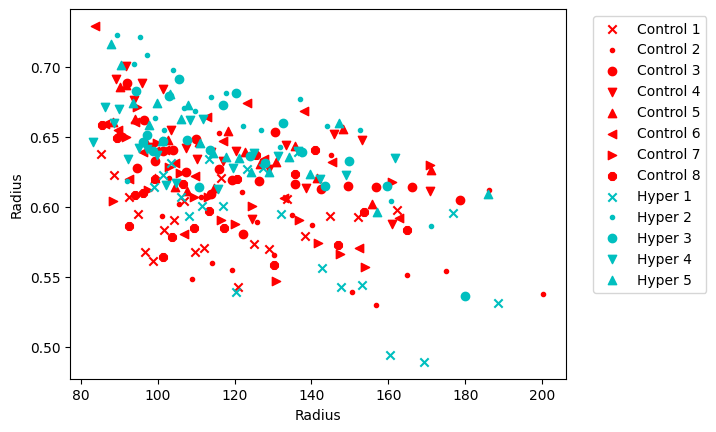

In [8]:
plt.scatter(c1x,c1y, c='r', marker='x', label='Control 1')
plt.scatter(c2x,c2y, c='r', marker='.', label='Control 2')
plt.scatter(c3x,c3y, c='r', marker='o', label='Control 3')
plt.scatter(c4x,c4y, c='r', marker='v', label='Control 4')
plt.scatter(c5x,c5y, c='r', marker='^', label='Control 5')
plt.scatter(c6x,c6y, c='r', marker='<', label='Control 6')
plt.scatter(c7x,c7y, c='r', marker='>', label='Control 7')
plt.scatter(c8x,c8y, c='r', marker='8', label='Control 8')
plt.scatter(h1x,h1y, c='c', marker='x', label='Hyper 1')
plt.scatter(h2x,h2y, c='c', marker='.', label='Hyper 2')
plt.scatter(h3x,h3y, c='c', marker='o', label='Hyper 3')
plt.scatter(h4x,h4y, c='c', marker='v', label='Hyper 4')
plt.scatter(h5x,h5y, c='c', marker='^', label='Hyper 5')
plt.ylabel(x)
plt.xlabel('Radius')
#plt.xlim([45, 180])
#plt.ylim([-1,17.5])
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

## Line of Best Fit LRR

In [9]:
# Bin Controls
y = 'Length/Radius'
x = 'Radius'
c1x,c1y = bintoPlot(control1,y,x)
c2x,c2y = bintoPlot(control2,y,x)
c3x,c3y = bintoPlot(control3,y,x)
c4x,c4y = bintoPlot(control4,y,x)
c5x,c5y = bintoPlot(control5,y,x)
c6x,c6y = bintoPlot(control6,y,x)
c7x,c7y = bintoPlot(control7,y,x)
c8x,c8y = bintoPlot(control8,y,x)
# Bin Hypertensives
h1x,h1y = bintoPlot(hyper1,y,x)
h2x,h2y = bintoPlot(hyper2,y,x)
h3x,h3y = bintoPlot(hyper3,y,x)
h4x,h4y = bintoPlot(hyper4,y,x)
h5x,h5y = bintoPlot(hyper5,y,x)

In [10]:
controly = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
controlx = np.concat((c1x,c2x,c3x,c4x,c5x,c6x,c7x,c8x),axis=0)
hypery = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hyperx = np.concat((h1x,h2x,h3x,h4x,h5x),axis=0)

paramsc, _ = curve_fit(exponential, controlx, controly,p0=[10, 0.008])
paramsh, _ = curve_fit(exponential, hyperx, hypery,p0=[10, 0.008])
print(paramsc)
print(paramsh)
x_range = np.linspace(min(min(hyperx),min(controlx)),max(max(hyperx),max(controlx)), 1000)
c_fit = exponential(x_range, *paramsc)
h_fit = exponential(x_range, *paramsh)

[2.24241386e+01 1.28588915e-02]
[1.92338701e+01 1.21612345e-02]


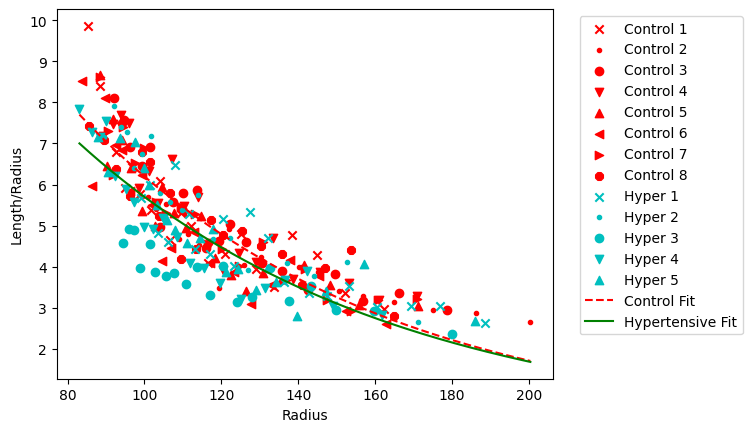

In [11]:
plt.scatter(c1x,c1y, c='r', marker='x', label='Control 1')
plt.scatter(c2x,c2y, c='r', marker='.', label='Control 2')
plt.scatter(c3x,c3y, c='r', marker='o', label='Control 3')
plt.scatter(c4x,c4y, c='r', marker='v', label='Control 4')
plt.scatter(c5x,c5y, c='r', marker='^', label='Control 5')
plt.scatter(c6x,c6y, c='r', marker='<', label='Control 6')
plt.scatter(c7x,c7y, c='r', marker='>', label='Control 7')
plt.scatter(c8x,c8y, c='r', marker='8', label='Control 8')
plt.scatter(h1x,h1y, c='c', marker='x', label='Hyper 1')
plt.scatter(h2x,h2y, c='c', marker='.', label='Hyper 2')
plt.scatter(h3x,h3y, c='c', marker='o', label='Hyper 3')
plt.scatter(h4x,h4y, c='c', marker='v', label='Hyper 4')
plt.scatter(h5x,h5y, c='c', marker='^', label='Hyper 5')
plt.plot(x_range, c_fit, color='red', linestyle='--', label='Control Fit')
plt.plot(x_range, h_fit, color='green', linestyle='-', label='Hypertensive Fit')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel(x)
plt.ylabel(y)
plt.show()

# By Depth Comparison

In [12]:
def totalVolume(data):
    v = data.groupby('Depth')['Volume'].sum()/(1000**3)
    d = data.groupby('Depth')['Depth'].count()
    p = np.arange(0, len(d))
    return v, d, p

In [13]:
# Extract controls
c1v, c1d, c1p = totalVolume(control1)
c2v, c2d, c2p = totalVolume(control2)
c3v, c3d, c3p = totalVolume(control3)
c4v, c4d, c4p = totalVolume(control4)
c5v, c5d, c5p = totalVolume(control5)
c6v, c6d, c6p = totalVolume(control6)
c7v, c7d, c7p = totalVolume(control7)
c8v, c8d, c8p = totalVolume(control8)

In [41]:
h1v,h1d,h1p = totalVolume(hyper1)
h2v,h2d,h2p = totalVolume(hyper2)
h3v,h3d,h3p = totalVolume(hyper3)
h4v,h4d,h4p = totalVolume(hyper4)
h5v,h5d,h5p = totalVolume(hyper5)

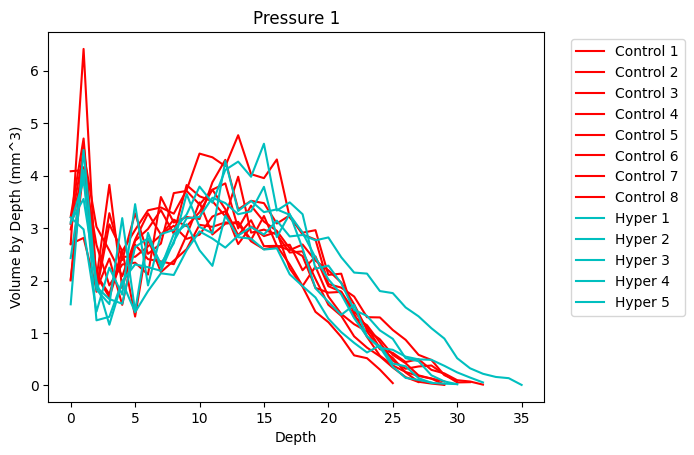

In [42]:
plt.plot(c1p,c1v,label='Control 1',color='r')
plt.plot(c2p,c2v,label='Control 2',color='r')
plt.plot(c3p,c3v,label='Control 3',color='r')
plt.plot(c4p,c4v,label='Control 4',color='r')
plt.plot(c5p,c5v,label='Control 5',color='r')
plt.plot(c6p,c6v,label='Control 6',color='r')
plt.plot(c7p,c7v,label='Control 7',color='r')
plt.plot(c8p,c8v,label='Control 8',color='r')
plt.plot(h1p,h1v,label='Hyper 1',color='c')
plt.plot(h2p,h2v,label='Hyper 2',color='c')
plt.plot(h3p,h3v,label='Hyper 3',color='c')
plt.plot(h4p,h4v,label='Hyper 4',color='c')
plt.plot(h5p,h5v,label='Hyper 5',color='c')
plt.ylabel('Volume by Depth (mm^3)')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.title('Pressure 1')
plt.show()

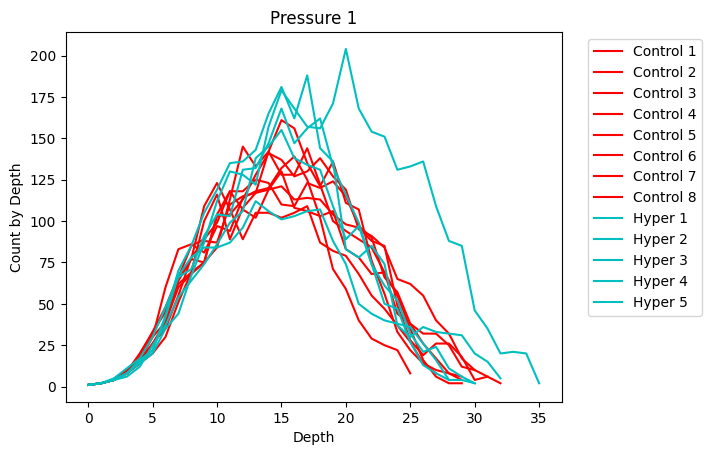

In [43]:
plt.plot(c1p,c1d,label='Control 1',color='r')
plt.plot(c2p,c2d,label='Control 2',color='r')
plt.plot(c3p,c3d,label='Control 3',color='r')
plt.plot(c4p,c4d,label='Control 4',color='r')
plt.plot(c5p,c5d,label='Control 5',color='r')
plt.plot(c6p,c6d,label='Control 6',color='r')
plt.plot(c7p,c7d,label='Control 7',color='r')
plt.plot(c8p,c8d,label='Control 8',color='r')
plt.plot(h1p,h1d,label='Hyper 1',color='c')
plt.plot(h2p,h2d,label='Hyper 2',color='c')
plt.plot(h3p,h3d,label='Hyper 3',color='c')
plt.plot(h4p,h4d,label='Hyper 4',color='c')
plt.plot(h5p,h5d,label='Hyper 5',color='c')
plt.ylabel('Count by Depth')
plt.xlabel('Depth')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.title('Pressure 1')
plt.show()

In [20]:
leaveDetails(hyper5)

# of vessels: 2163
# of leaves (terminal vessels): 1139
# of internal vessels: 1024
# of trifurcations: 114
% of trifurcations: 11.133
Volume (mm^3): 65.878
Average Depth of terminal vessel: 15.916
St. Dev. Depth of terminal vessel: 4.963


# Off Principal Pathway Comparisons

# Off Principal Pathway Comparisons

In [5]:
def lobeExtractor(name, vesID):
    data = dataExtractor(name)
    
    tree = defaultdict(list)
    for _,row in data.iterrows():
        parent = row['Parent']
        for daughter_col in ['Daughter1','Daughter2','Daughter3']:
            daughter = row[daughter_col]
            if pd.notna(daughter):
                tree[parent].append(daughter)

    visited = set()
    queue = deque([vesID])

    while queue:
        current = queue.popleft()
        if current not in visited:
            visited.add(current)
            queue.extend(tree.get(current,[]))
    
    downstream_df = data[data['Parent'].isin(visited) | data['Parent'].isin([vesID])]
    return downstream_df.reset_index()


def lobeInput(name,fromnode,tonode):
    segments = edgesExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, segments, on='Old', how='left')
    newVesID = int(newOldIDs[((newOldIDs['From'] == fromnode)&(newOldIDs['To']==tonode))].iloc[0,0])
    lobe = lobeExtractor(name,newVesID)
    return lobe

def offPrincipalPath(data):
    # Initialize BFS queue and results
    queue = deque([0])  # Start with the first row
    visited = set()
    principal_path = []

    # Get the initial radius
    root_radius = data.loc[0, 'Radius']

    while queue:
        current = queue.popleft()
        if current in visited:
            continue
        visited.add(current)
        principal_path.append(current)

        # Parent radius
        parent_radius = data.loc[current, 'Radius']

        # Check each daughter
        for i in range(1, 4):
            daughter_col = f'Daughter{i}'
            dvr_col = f'DV{i}R'

            if daughter_col in data.columns and dvr_col in data.columns:
                daughter = data.loc[current, daughter_col]
                dvr = data.loc[current, dvr_col]

                if not pd.isna(daughter) and not pd.isna(dvr):
                    if dvr >= 0.4 * root_radius:
                        queue.append(int(daughter))
    off_path_df = data[~data['Parent'].isin(principal_path)].copy()
    # Now filter for Radius > 0.2 * root_radius
    off_path_df = off_path_df[off_path_df['Radius'] > 0.2 * root_radius].copy()
    return off_path_df
    

def bintoPlot(data,y,x):
    filtered = offPrincipalPath(data)
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered[x].rank(method='first'), 20,labels = labels)
    a = filtered.groupby('binned')[x].mean()
    b = filtered.groupby('binned')[y].mean()
    return a,b

def exponential(x, a, b):
    return a * np.exp(-b * x)
    #return a*(x**-b)

def percOPP(data):
    opp = offPrincipalPath(data)
    print(opp.shape[0])
    percent = opp.shape[0]/data.shape[0]*100
    return percent

In [ ]:
left_lobe = lobeInput('m1p4_060107',215,1664)
opp = offPrincipalPath(hyper1)
print(left_lobe[left_lobe['Parent'].isin(opp['Parent'])].shape[0])
print(left_lobe['Volume'].sum()/(1000**3))

96
11.243511185515034


In [ ]:
# Bin Controls
y = 'Beta'
x = 'Radius'
c1x,c1y = bintoPlot(control1,y,x)
c2x,c2y = bintoPlot(control2,y,x)
c3x,c3y = bintoPlot(control3,y,x)
c4x,c4y = bintoPlot(control4,y,x)
c5x,c5y = bintoPlot(control5,y,x)
c6x,c6y = bintoPlot(control6,y,x)
c7x,c7y = bintoPlot(control7,y,x)
c8x,c8y = bintoPlot(control8,y,x)

In [ ]:
# Bin Hypertensives
h1x,h1y = bintoPlot(hyper1,y,x)
h2x,h2y = bintoPlot(hyper2,y,x)
h3x,h3y = bintoPlot(hyper3,y,x)
h4x,h4y = bintoPlot(hyper4,y,x)
h5x,h5y = bintoPlot(hyper5,y,x)

In [ ]:
control = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
conavg = np.mean(control)
hyper = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hypavg = np.mean(hyper)
print(conavg)
print(hypavg)

0.6050292160451328
0.6028167701443157


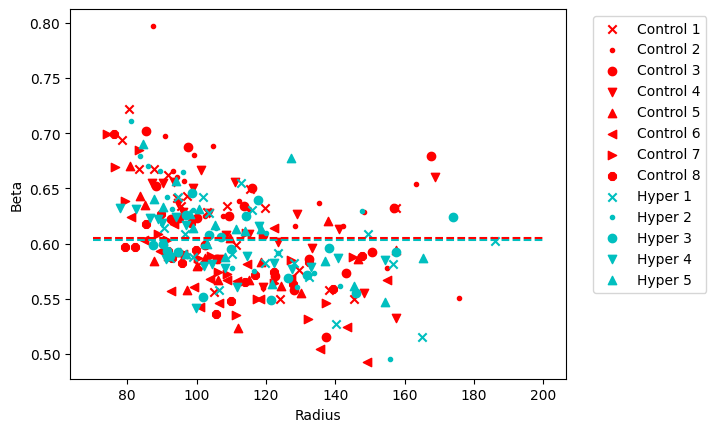

In [ ]:
plt.scatter(c1x,c1y, c='r', marker='x', label='Control 1')
plt.scatter(c2x,c2y, c='r', marker='.', label='Control 2')
plt.scatter(c3x,c3y, c='r', marker='o', label='Control 3')
plt.scatter(c4x,c4y, c='r', marker='v', label='Control 4')
plt.scatter(c5x,c5y, c='r', marker='^', label='Control 5')
plt.scatter(c6x,c6y, c='r', marker='<', label='Control 6')
plt.scatter(c7x,c7y, c='r', marker='>', label='Control 7')
plt.scatter(c8x,c8y, c='r', marker='8', label='Control 8')
plt.scatter(h1x,h1y, c='c', marker='x', label='Hyper 1')
plt.scatter(h2x,h2y, c='c', marker='.', label='Hyper 2')
plt.scatter(h3x,h3y, c='c', marker='o', label='Hyper 3')
plt.scatter(h4x,h4y, c='c', marker='v', label='Hyper 4')
plt.scatter(h5x,h5y, c='c', marker='^', label='Hyper 5')
plt.hlines(y=[hypavg,conavg],xmin=70,xmax=200,colors=['c','r'],linestyles=['--','--'])
plt.ylabel(y)
plt.xlabel(x)
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

## Line of Best Fit LRR

In [ ]:
# Bin Controls
y = 'Length/Radius'
x = 'Radius'
c1x,c1y = bintoPlot(control1,y,x)
c2x,c2y = bintoPlot(control2,y,x)
c3x,c3y = bintoPlot(control3,y,x)
c4x,c4y = bintoPlot(control4,y,x)
c5x,c5y = bintoPlot(control5,y,x)
c6x,c6y = bintoPlot(control6,y,x)
c7x,c7y = bintoPlot(control7,y,x)
c8x,c8y = bintoPlot(control8,y,x)
# Bin Hypertensives
h1x,h1y = bintoPlot(hyper1,y,x)
h2x,h2y = bintoPlot(hyper2,y,x)
h3x,h3y = bintoPlot(hyper3,y,x)
h4x,h4y = bintoPlot(hyper4,y,x)
h5x,h5y = bintoPlot(hyper5,y,x)

In [ ]:
controly = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
controlx = np.concat((c1x,c2x,c3x,c4x,c5x,c6x,c7x,c8x),axis=0)
hypery = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hyperx = np.concat((h1x,h2x,h3x,h4x,h5x),axis=0)

paramsc, _ = curve_fit(exponential, controlx, controly,p0=[10, 0.008])
paramsh, _ = curve_fit(exponential, hyperx, hypery,p0=[10, 0.008])
print(paramsc)
print(paramsh)
x_range = np.linspace(min(min(hyperx),min(controlx)),max(max(hyperx),max(controlx)), 1000)
c_fit = exponential(x_range, *paramsc)
h_fit = exponential(x_range, *paramsh)

[3.79679079e+01 1.58977642e-02]
[2.20134467e+01 1.28027210e-02]


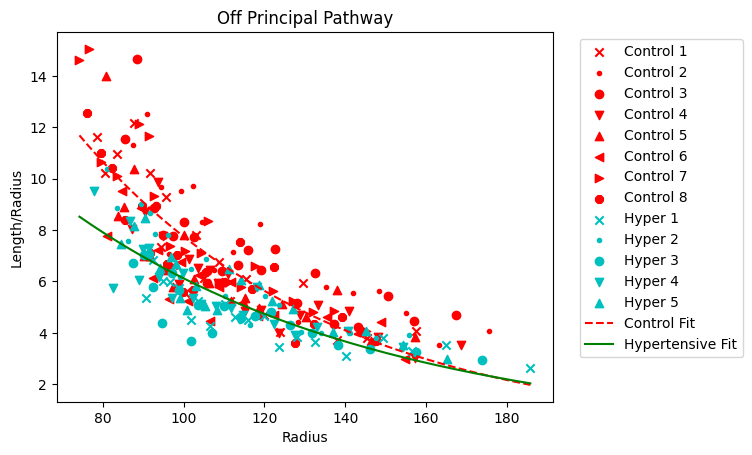

In [ ]:
plt.scatter(c1x,c1y, c='r', marker='x', label='Control 1')
plt.scatter(c2x,c2y, c='r', marker='.', label='Control 2')
plt.scatter(c3x,c3y, c='r', marker='o', label='Control 3')
plt.scatter(c4x,c4y, c='r', marker='v', label='Control 4')
plt.scatter(c5x,c5y, c='r', marker='^', label='Control 5')
plt.scatter(c6x,c6y, c='r', marker='<', label='Control 6')
plt.scatter(c7x,c7y, c='r', marker='>', label='Control 7')
plt.scatter(c8x,c8y, c='r', marker='8', label='Control 8')
plt.scatter(h1x,h1y, c='c', marker='x', label='Hyper 1')
plt.scatter(h2x,h2y, c='c', marker='.', label='Hyper 2')
plt.scatter(h3x,h3y, c='c', marker='o', label='Hyper 3')
plt.scatter(h4x,h4y, c='c', marker='v', label='Hyper 4')
plt.scatter(h5x,h5y, c='c', marker='^', label='Hyper 5')
plt.plot(x_range, c_fit, color='red', linestyle='--', label='Control Fit')
plt.plot(x_range, h_fit, color='green', linestyle='-', label='Hypertensive Fit')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel(x)
plt.ylabel(y)
plt.title('Off Principal Pathway')
plt.show()

# SIPAs

In [6]:
def lobeInput(name,fromnode,tonode):
    segments = segmentExtractor(name)
    maps = mapIDExtractor(name)
    newOldIDs = pd.merge(maps, segments, on='Old', how='left')
    newVesID = int(newOldIDs[((newOldIDs['From'] == fromnode)&(newOldIDs['To']==tonode))].iloc[0,0])
    lobe = lobeExtractor(name,newVesID)
    return lobe

def SIPAs(data):
    # Initialize BFS queue and results
    queue = deque([0])  # Start with the first row
    visited = set()
    principal_path = []

    # Get the initial radius
    root_radius = data.loc[0, 'Radius']

    while queue:
        current = queue.popleft()
        if current in visited:
            continue
        visited.add(current)
        principal_path.append(current)

        # Parent radius
        parent_radius = data.loc[current, 'Radius']

        # Check each daughter
        for i in range(1, 4):
            daughter_col = f'Daughter{i}'
            dvr_col = f'DV{i}R'

            if daughter_col in data.columns and dvr_col in data.columns:
                daughter = data.loc[current, daughter_col]
                dvr = data.loc[current, dvr_col]

                if not pd.isna(daughter) and not pd.isna(dvr):
                    if dvr >= 0.2 * root_radius:
                        queue.append(int(daughter))
    off_path_df = data[~data['Parent'].isin(principal_path)].copy()
    return off_path_df
    

def bintoPlotS(data,y,x):
    filtered = SIPAs(data)
    labels = np.arange(20)
    filtered['binned'] = pd.qcut(filtered[x].rank(method='first'), 20,labels = labels)
    a = filtered.groupby('binned')[x].mean()
    b = filtered.groupby('binned')[y].mean()
    return a,b

def exponential(x, a, b):
    return a * np.exp(-b * x)
    #return a*(x**-b)

def percSIPA(data):
    sipa = SIPAs(data)
    print(sipa.shape[0])
    percent = sipa.shape[0]/data.shape[0]*100
    return percent

In [ ]:
# Bin Controls
y = 'Gamma'
x = 'Radius'
c1xs,c1ys = bintoPlotS(control1,y,x)
c2xs,c2ys = bintoPlotS(control2,y,x)
c3xs,c3ys = bintoPlotS(control3,y,x)
c4xs,c4ys = bintoPlotS(control4,y,x)
c5xs,c5ys = bintoPlotS(control5,y,x)
c6xs,c6ys = bintoPlotS(control6,y,x)
c7xs,c7ys = bintoPlotS(control7,y,x)
c8xs,c8ys = bintoPlotS(control8,y,x)

In [ ]:
# Bin Hypertensives
h1xs,h1ys = bintoPlotS(hyper1,y,x)
h2xs,h2ys = bintoPlotS(hyper2,y,x)
h3xs,h3ys = bintoPlotS(hyper3,y,x)
h4xs,h4ys = bintoPlotS(hyper4,y,x)
h5xs,h5ys = bintoPlotS(hyper5,y,x)

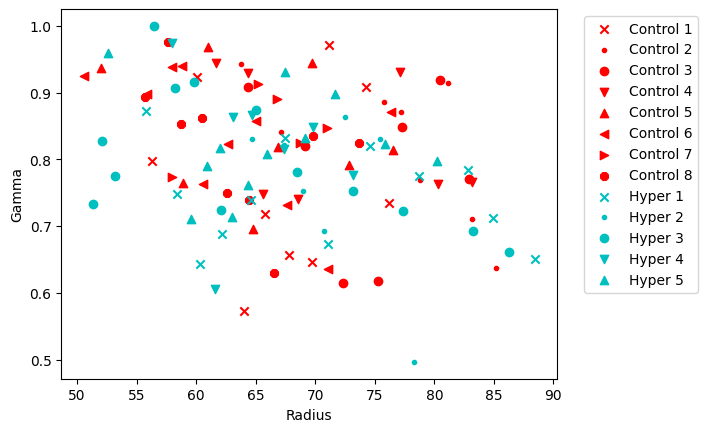

In [ ]:
plt.scatter(c1xs,c1ys, c='r', marker='x', label='Control 1')
plt.scatter(c2xs,c2ys, c='r', marker='.', label='Control 2')
plt.scatter(c3xs,c3ys, c='r', marker='o', label='Control 3')
plt.scatter(c4xs,c4ys, c='r', marker='v', label='Control 4')
plt.scatter(c5xs,c5ys, c='r', marker='^', label='Control 5')
plt.scatter(c6xs,c6ys, c='r', marker='<', label='Control 6')
plt.scatter(c7xs,c7ys, c='r', marker='>', label='Control 7')
plt.scatter(c8xs,c8ys, c='r', marker='8', label='Control 8')
plt.scatter(h1xs,h1ys, c='c', marker='x', label='Hyper 1')
plt.scatter(h2xs,h2ys, c='c', marker='.', label='Hyper 2')
plt.scatter(h3xs,h3ys, c='c', marker='o', label='Hyper 3')
plt.scatter(h4xs,h4ys, c='c', marker='v', label='Hyper 4')
plt.scatter(h5xs,h5ys, c='c', marker='^', label='Hyper 5')
plt.ylabel(y)
plt.xlabel(x)
#plt.xlim([45, 180])
#plt.ylim([-1,17.5])
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')

In [19]:
#calculate % of vessels in principal path vs SIPAs
print('OPP: ' + str(percOPP(hyper5)))
print('SIPA: ' + str(percSIPA(hyper5)))

946
OPP: 43.73555247341655
1063
SIPA: 49.14470642625982


## Line of Best Fit LRR

In [ ]:
# Bin Controls
y = 'Length/Radius'
x = 'Radius'
c1x,c1y = bintoPlotS(control1,y,x)
c2x,c2y = bintoPlotS(control2,y,x)
c3x,c3y = bintoPlotS(control3,y,x)
c4x,c4y = bintoPlotS(control4,y,x)
c5x,c5y = bintoPlotS(control5,y,x)
c6x,c6y = bintoPlotS(control6,y,x)
c7x,c7y = bintoPlotS(control7,y,x)
c8x,c8y = bintoPlotS(control8,y,x)
# Bin Hypertensives
h1x,h1y = bintoPlotS(hyper1,y,x)
h2x,h2y = bintoPlotS(hyper2,y,x)
h3x,h3y = bintoPlotS(hyper3,y,x)
h4x,h4y = bintoPlotS(hyper4,y,x)
h5x,h5y = bintoPlotS(hyper5,y,x)

In [ ]:
controly = np.concat((c1y,c2y,c3y,c4y,c5y,c6y,c7y,c8y),axis=0)
controlx = np.concat((c1x,c2x,c3x,c4x,c5x,c6x,c7x,c8x),axis=0)
hypery = np.concat((h1y,h2y,h3y,h4y,h5y),axis=0)
hyperx = np.concat((h1x,h2x,h3x,h4x,h5x),axis=0)

paramsc, _ = curve_fit(exponential, controlx, controly,p0=[10, 0.008])
paramsh, _ = curve_fit(exponential, hyperx, hypery,p0=[10, 0.008])
print(paramsc)
print(paramsh)
x_range = np.linspace(min(min(hyperx),min(controlx)),max(max(hyperx),max(controlx)), 1000)
c_fit = exponential(x_range, *paramsc)
h_fit = exponential(x_range, *paramsh)

[2.89025405e+01 1.24891287e-02]
[2.78876211e+01 1.46367762e-02]


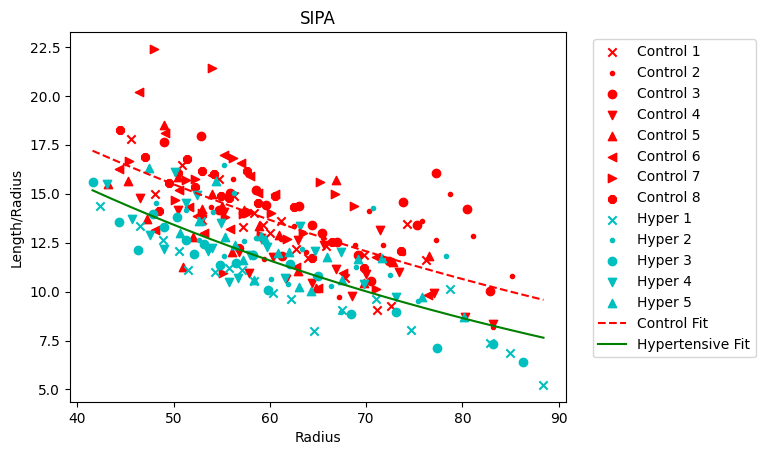

In [ ]:
plt.scatter(c1x,c1y, c='r', marker='x', label='Control 1')
plt.scatter(c2x,c2y, c='r', marker='.', label='Control 2')
plt.scatter(c3x,c3y, c='r', marker='o', label='Control 3')
plt.scatter(c4x,c4y, c='r', marker='v', label='Control 4')
plt.scatter(c5x,c5y, c='r', marker='^', label='Control 5')
plt.scatter(c6x,c6y, c='r', marker='<', label='Control 6')
plt.scatter(c7x,c7y, c='r', marker='>', label='Control 7')
plt.scatter(c8x,c8y, c='r', marker='8', label='Control 8')
plt.scatter(h1x,h1y, c='c', marker='x', label='Hyper 1')
plt.scatter(h2x,h2y, c='c', marker='.', label='Hyper 2')
plt.scatter(h3x,h3y, c='c', marker='o', label='Hyper 3')
plt.scatter(h4x,h4y, c='c', marker='v', label='Hyper 4')
plt.scatter(h5x,h5y, c='c', marker='^', label='Hyper 5')
plt.plot(x_range, c_fit, color='red', linestyle='--', label='Control Fit')
plt.plot(x_range, h_fit, color='green', linestyle='-', label='Hypertensive Fit')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.xlabel(x)
plt.ylabel(y)
plt.title('SIPA')
plt.show()